In [ ]:
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.offline import iplot , plot
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)
from plotly.subplots import make_subplots
from sklearn.preprocessing import MinMaxScaler , LabelEncoder , StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier , BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import  ConfusionMatrixDisplay, classification_report , accuracy_score , confusion_matrix
import warnings
warnings.filterwarnings('ignore')


## Reading Dataset And Get Info


In [2]:
df = pd.read_csv('loan_data.csv')

In [3]:
# Show Sample of Data
df.sample(5)

person_age person_gender person_education  person_income  \
43060        24.0        female        Associate        31173.0   
18910        32.0          male        Associate        56042.0   
9720         24.0          male      High School        77959.0   
31310        43.0        female        Associate       104206.0   
21243        28.0        female        Associate        36633.0   

       person_emp_exp person_home_ownership  loan_amnt      loan_intent  \
43060               0                  RENT     8500.0          MEDICAL   
18910              11                  RENT     1800.0          MEDICAL   
9720                5              MORTGAGE     6000.0          VENTURE   
31310              21              MORTGAGE     6500.0  HOMEIMPROVEMENT   
21243               5                  RENT     5200.0         PERSONAL   

       loan_int_rate  loan_percent_income  cb_person_cred_hist_length  \
43060          12.81                 0.27                         2.0   
18910          11.58                 0.03                         9.0   
9720           10.75                 0.08                         3.0   
31310           7.74                 0.06                        13.0   
21243           5.42                 0.14                         7.0   

       credit_score previous_loan_defaults_on_file  loan_status  
43060           616                             No            1  
18910           657                            Yes            0  
9720            691                            Yes            0  
31310           663                            Yes            0  
21243           583                            Yes            0

In [4]:
# Show Shape of Data
print(f"Number of Row : {df.shape[0]}\nNumber of Columns : {df.shape[1]}")

Number of Row : 45000
Number of Columns : 14


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      45000 non-null  float64
 1   person_gender                   45000 non-null  object 
 2   person_education                45000 non-null  object 
 3   person_income                   45000 non-null  float64
 4   person_emp_exp                  45000 non-null  int64  
 5   person_home_ownership           45000 non-null  object 
 6   loan_amnt                       45000 non-null  float64
 7   loan_intent                     45000 non-null  object 
 8   loan_int_rate                   45000 non-null  float64
 9   loan_percent_income             45000 non-null  float64
 10  cb_person_cred_hist_length      45000 non-null  float64
 11  credit_score                    45000 non-null  int64  
 12  previous_loan_defaults_on_file  

In [6]:
# Check for Data Leakage
pd.crosstab(df['previous_loan_defaults_on_file'], df['loan_status'], normalize='index')

loan_status                           0        1
previous_loan_defaults_on_file                  
No                              0.54837  0.45163
Yes                             1.00000  0.00000

In [7]:
# Remove 'previous_loan_defaults_on_file' cause that lead to data leakage
df = df.drop(columns=['previous_loan_defaults_on_file'])

In [8]:
# Check NaN Value
df.isna().sum()

person_age                    0
person_gender                 0
person_education              0
person_income                 0
person_emp_exp                0
person_home_ownership         0
loan_amnt                     0
loan_intent                   0
loan_int_rate                 0
loan_percent_income           0
cb_person_cred_hist_length    0
credit_score                  0
loan_status                   0
dtype: int64

In [9]:
# Describe Numiric Data
df.describe()

person_age  person_income  person_emp_exp     loan_amnt  \
count  45000.000000   4.500000e+04    45000.000000  45000.000000   
mean      27.764178   8.031905e+04        5.410333   9583.157556   
std        6.045108   8.042250e+04        6.063532   6314.886691   
min       20.000000   8.000000e+03        0.000000    500.000000   
25%       24.000000   4.720400e+04        1.000000   5000.000000   
50%       26.000000   6.704800e+04        4.000000   8000.000000   
75%       30.000000   9.578925e+04        8.000000  12237.250000   
max      144.000000   7.200766e+06      125.000000  35000.000000   

       loan_int_rate  loan_percent_income  cb_person_cred_hist_length  \
count   45000.000000         45000.000000                45000.000000   
mean       11.006606             0.139725                    5.867489   
std         2.978808             0.087212                    3.879702   
min         5.420000             0.000000                    2.000000   
25%         8.590000             0.070000                    3.000000   
50%        11.010000             0.120000                    4.000000   
75%        12.990000             0.190000                    8.000000   
max        20.000000             0.660000                   30.000000   

       credit_score   loan_status  
count  45000.000000  45000.000000  
mean     632.608756      0.222222  
std       50.435865      0.415744  
min      390.000000      0.000000  
25%      601.000000      0.000000  
50%      640.000000      0.000000  
75%      670.000000      0.000000  
max      850.000000      1.000000

- Maximum person age 144 not reality
- person_income (Annual income) and person_emp_exp (Years of employment experience) in my opinion contain outlier

In [10]:
pd.DataFrame({'Count':df.shape[0],
              'Null':df.isnull().sum(),
              'Null %':df.isnull().mean() * 100,
              'Cardinality':df.nunique()
})

Count  Null  Null %  Cardinality
person_age                  45000     0     0.0           60
person_gender               45000     0     0.0            2
person_education            45000     0     0.0            5
person_income               45000     0     0.0        33989
person_emp_exp              45000     0     0.0           63
person_home_ownership       45000     0     0.0            4
loan_amnt                   45000     0     0.0         4483
loan_intent                 45000     0     0.0            6
loan_int_rate               45000     0     0.0         1302
loan_percent_income         45000     0     0.0           64
cb_person_cred_hist_length  45000     0     0.0           29
credit_score                45000     0     0.0          340
loan_status                 45000     0     0.0            2

## Detecting Outliers

In [11]:
def detect_outliers_iqr(df, columns, threshold = 1.5):

    outlier_indices = {}

    for col in columns:
        Q1 = df[col].quantile(0.25)  # 25th percentile
        Q3 = df[col].quantile(0.75)  # 75th percentile
        IQR = Q3 - Q1  # Interquartile range
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR

        # Finding outliers
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)].index.tolist()
        outlier_indices[col] = outliers
    
    return outlier_indices

numerical_columns = ['person_age','person_income','person_emp_exp','loan_amnt','loan_int_rate','loan_percent_income',
                     'cb_person_cred_hist_length','credit_score']
outliers_iqr = detect_outliers_iqr(df, numerical_columns)

for col, indices in outliers_iqr.items():
    print(f"{col}: {len(indices)} outliers detected")

person_age: 2188 outliers detected
person_income: 2218 outliers detected
person_emp_exp: 1724 outliers detected
loan_amnt: 2348 outliers detected
loan_int_rate: 124 outliers detected
loan_percent_income: 744 outliers detected
cb_person_cred_hist_length: 1366 outliers detected
credit_score: 467 outliers detected


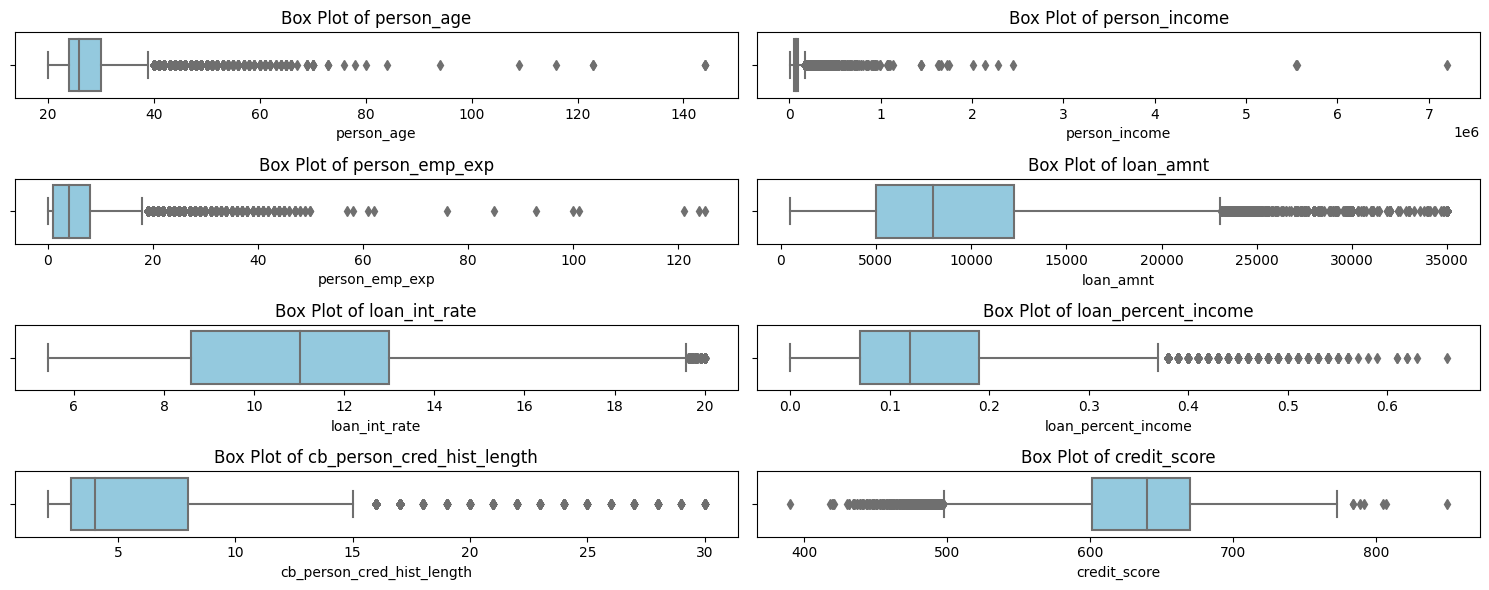

In [12]:
plt.figure(figsize=(15, 6))

for i, col in enumerate(numerical_columns, 1):
    plt.subplot(4, 2, i)  
    sns.boxplot(x = df[col], color = "skyblue")
    plt.title(f"Box Plot of {col}")

plt.tight_layout() 
plt.show()

In [13]:
def remove_outliers(df, columns, threshold = 1.5):
    df_clean = df.copy()
    for col in columns:
        Q1 = df_clean[col].quantile(0.25)  # First quartile (25%)
        Q3 = df_clean[col].quantile(0.75)  # Third quartile (75%)
        IQR = Q3 - Q1  # Interquartile range
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        
        df_clean = df_clean[(df_clean[col] > lower_bound) & (df_clean[col] < upper_bound)]
    
    return df_clean

df_cleaned = remove_outliers(df, numerical_columns)

In [14]:
# The New of Shape Cleaned Data
print(f"Number of Row : {df_cleaned.shape[0]}\nNumber of Columns : {df_cleaned.shape[1]}")

Number of Row : 35630
Number of Columns : 13


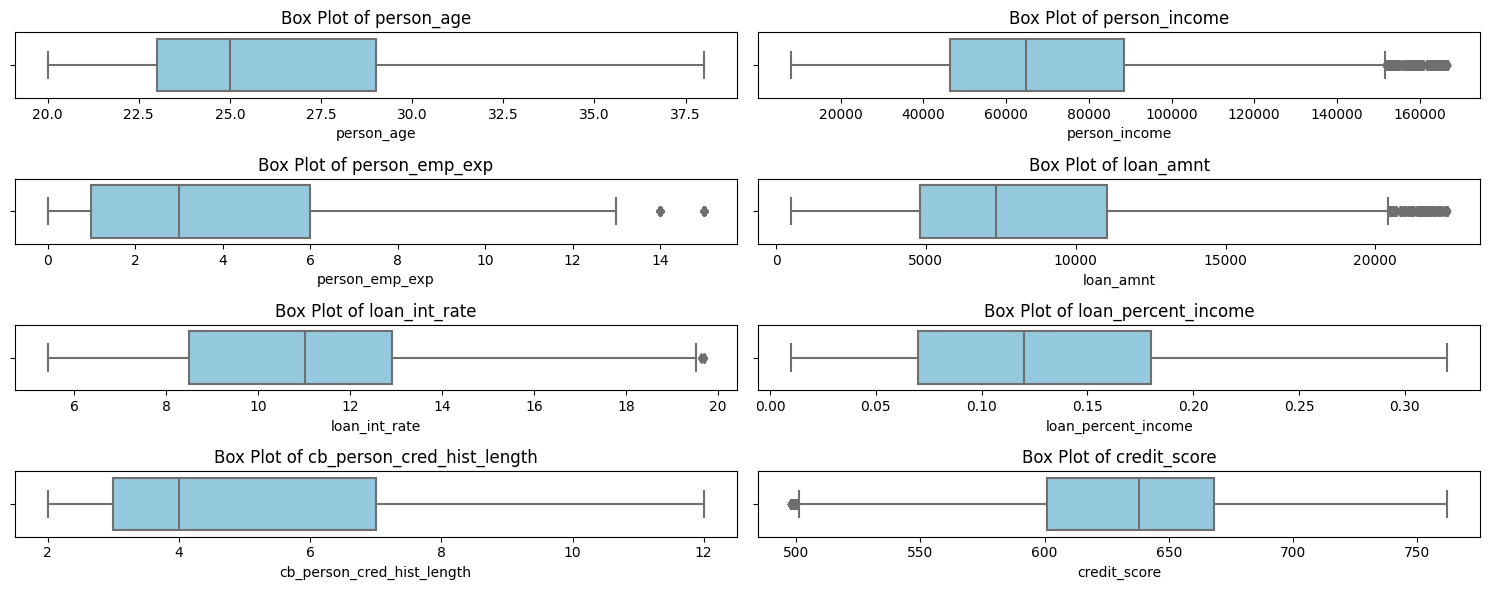

In [15]:
plt.figure(figsize=(15, 6))

for i, col in enumerate(numerical_columns, 1):
    plt.subplot(4, 2, i) 
    sns.boxplot(x = df_cleaned[col], color = "skyblue")
    plt.title(f"Box Plot of {col}")

plt.tight_layout()
plt.show()

In [16]:
df_cleaned.reset_index(inplace = True , drop = True)
df_cleaned.sample(5)

person_age person_gender person_education  person_income  \
26616        31.0          male        Associate       145207.0   
15441        22.0          male      High School        79956.0   
26604        26.0          male      High School        49491.0   
16536        29.0          male        Associate        38948.0   
16333        27.0        female         Bachelor        29874.0   

       person_emp_exp person_home_ownership  loan_amnt loan_intent  \
26616               8              MORTGAGE     6000.0    PERSONAL   
15441               4              MORTGAGE    10000.0     VENTURE   
26604               3              MORTGAGE     6508.0     VENTURE   
16536               8                  RENT     2100.0    PERSONAL   
16333               4                  RENT     1450.0     MEDICAL   

       loan_int_rate  loan_percent_income  cb_person_cred_hist_length  \
26616          10.53                 0.04                         8.0   
15441          11.49                 0.13                         4.0   
26604           9.53                 0.13                         5.0   
16536          11.01                 0.05                         6.0   
16333          11.01                 0.05                         9.0   

       credit_score  loan_status  
26616           598            0  
15441           572            0  
26604           591            0  
16536           596            0  
16333           690            0

In [17]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35630 entries, 0 to 35629
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  35630 non-null  float64
 1   person_gender               35630 non-null  object 
 2   person_education            35630 non-null  object 
 3   person_income               35630 non-null  float64
 4   person_emp_exp              35630 non-null  int64  
 5   person_home_ownership       35630 non-null  object 
 6   loan_amnt                   35630 non-null  float64
 7   loan_intent                 35630 non-null  object 
 8   loan_int_rate               35630 non-null  float64
 9   loan_percent_income         35630 non-null  float64
 10  cb_person_cred_hist_length  35630 non-null  float64
 11  credit_score                35630 non-null  int64  
 12  loan_status                 35630 non-null  int64  
dtypes: float64(6), int64(3), object


EDA of Data and Get Insights


#### Does Age Affect on Their Status of Loan ?

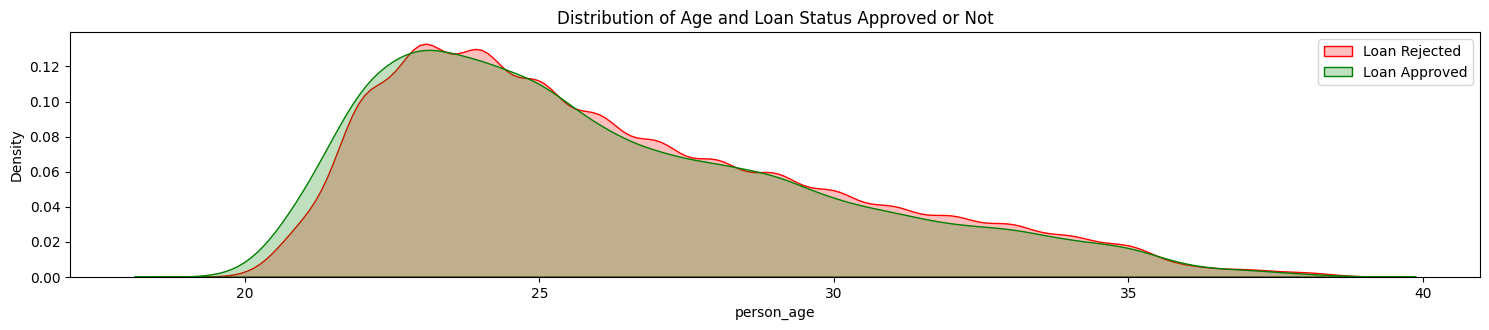

In [18]:
plt.figure(figsize=(15,6))

plt.subplot(2,1,1)

plt.title('Distribution of Age and Loan Status Approved or Not')
sns.kdeplot(df_cleaned[(df_cleaned['loan_status'] == 0)]['person_age'],color='red',fill=True,label='Loan Rejected')
sns.kdeplot(df_cleaned[(df_cleaned['loan_status'] == 1)]['person_age'],color='green',fill=True,label='Loan Approved')

plt.legend()
plt.tight_layout()
plt.show()

- Most of the ages of those who are accepted for loans range between 20 and 25. After this age, obtaining loans becomes more difficult.

#### What is the gender of those whose loan application is accepted more ?

In [19]:
fig = px.pie(values = df_cleaned['person_gender'].value_counts(),
             names = ['male','female'],
             template = 'plotly_dark',
             title = 'The Percentage of Gender'
             ).update_traces(textinfo='label+percent')
fig.show()

- Males are the most in demand for loans.

In [20]:
fig = px.histogram(
    df_cleaned, 
    x='person_gender', 
    color='loan_status', 
    barmode='group',  
    title='Loan Acceptance by Gender (1 = approved; 0 = rejected)',
    labels={'count': 'Count','loan_status':'Loan Status','person_gender':'Person Gender'},
    template='plotly_dark',
    text_auto=True,
    color_discrete_map = {0:'#c71818',1:'#05fa15'}
)
fig.show()


- Gender does not affect obtaining a loan.

#### Loan Approval by Education Level

In [21]:
fig = px.bar(df_cleaned['person_education'].value_counts(), 
    color=df_cleaned['person_education'].value_counts().index, 
    title='What most Education Level who needed Loan ?',
    labels={'person_education': 'Person Education','value':'Count','color':'Education Level'},
    template='plotly_dark',
    text_auto=True
)
fig.show()


- Most Education Level who needed Loan is Bachelor

In [22]:
fig = px.histogram(
    df_cleaned, 
    x='person_education', 
    color='loan_status', 
    barmode='group',  
    title='Loan Acceptance by Education Level (1 = approved; 0 = rejected)',
    labels={'count': 'Count','person_education': 'Person Education','loan_status':'Loan Status'},
    template='plotly_dark',
    text_auto=True,
    color_discrete_map = {0:'#c71818',1:'#05fa15'}
)
fig.show()

- Education Level not affect on Loan Approval

#### Annual income and Loan amount requested	

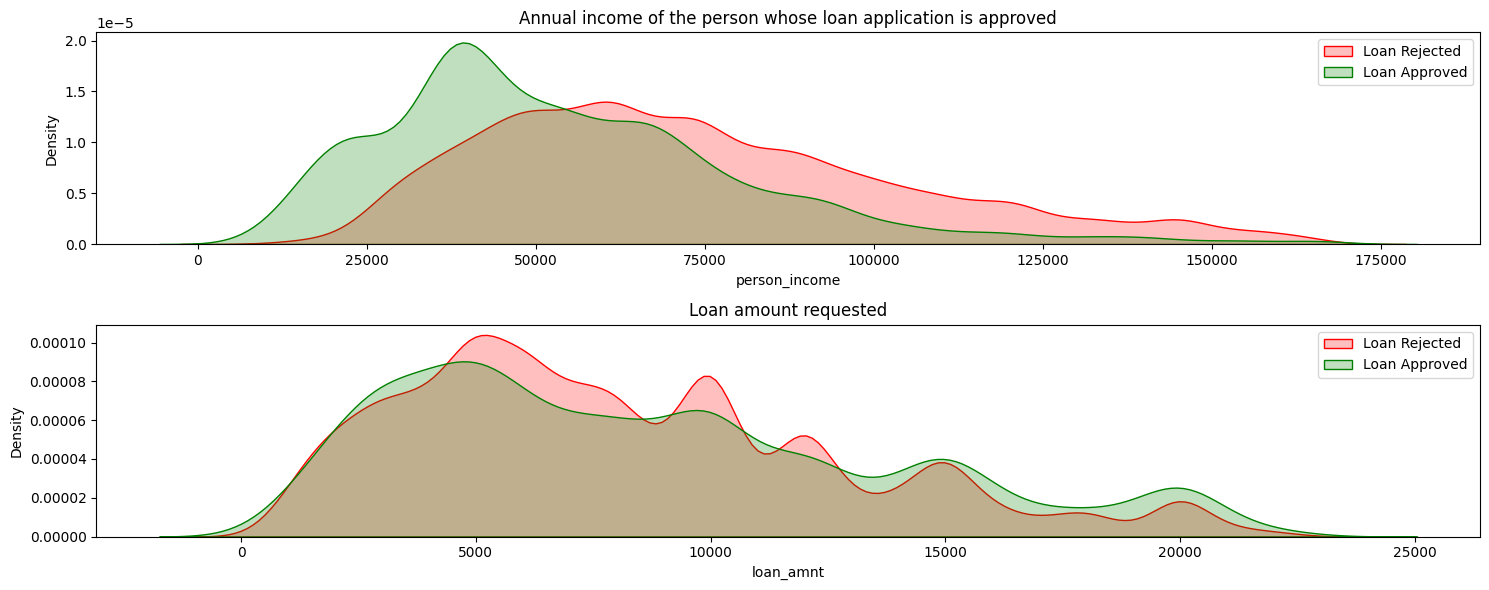

In [23]:
plt.figure(figsize=(15,6))

plt.subplot(2,1,1)

plt.title('Annual income of the person whose loan application is approved')
sns.kdeplot(df_cleaned[(df_cleaned['loan_status'] == 0)]['person_income'],color='red',fill=True,label='Loan Rejected')
sns.kdeplot(df_cleaned[(df_cleaned['loan_status'] == 1)]['person_income'],color='green',fill=True,label='Loan Approved')

plt.legend()

plt.subplot(2,1,2)

plt.title('Loan amount requested')
sns.kdeplot(df_cleaned[(df_cleaned['loan_status'] == 0)]['loan_amnt'],color='red',fill=True,label='Loan Rejected')
sns.kdeplot(df_cleaned[(df_cleaned['loan_status'] == 1)]['loan_amnt'],color='green',fill=True,label='Loan Approved')

plt.legend()
plt.tight_layout()
plt.show()

- Most annual income loan accepted less than 50000 (more than that rejected)
- loan amount accepted around than 15000 and more (less than may rejected)

In [24]:
df_cleaned.head()

person_age person_gender person_education  person_income  person_emp_exp  \
0        21.0        female      High School        12282.0               0   
1        21.0        female      High School        12951.0               0   
2        21.0        female      High School        12739.0               0   
3        24.0        female           Master        14283.0               1   
4        24.0        female         Bachelor        13866.0               0   

  person_home_ownership  loan_amnt loan_intent  loan_int_rate  \
0                   OWN     1000.0   EDUCATION          11.14   
1                   OWN     2500.0     VENTURE           7.14   
2                   OWN     1600.0     VENTURE          14.74   
3              MORTGAGE     1750.0   EDUCATION          10.99   
4                   OWN     1500.0    PERSONAL           7.29   

   loan_percent_income  cb_person_cred_hist_length  credit_score  loan_status  
0                 0.08                         2.0           504            0  
1                 0.19                         2.0           532            1  
2                 0.13                         3.0           640            1  
3                 0.12                         2.0           679            1  
4                 0.11                         3.0           600            0

##### Is Home ownership status affect ?

In [25]:
fig = px.histogram(
    df_cleaned, 
    x='person_home_ownership', 
    color='loan_status', 
    barmode='group',  
    title='Loan Acceptance by Home ownership status (1 = approved; 0 = rejected)',
    labels={'count': 'Count','person_home_ownership': 'Home ownership status','loan_status':'Loan Status'},
    template='plotly_dark',
    text_auto=True,
    color_discrete_map = {0:'#c71818',1:'#05fa15'}
)
fig.show()

- Most Approval are Home Ownership Rent

##### Total Insights
- Most of the ages of those who are accepted for loans range between 20 and 25. After this age, obtaining loans becomes more difficult.
- Males are the most in demand for loans.
- Gender does not affect obtaining a loan.
- Most Education Level who needed Loan is Bachelor
- Education Level not affect on Loan Approval
- Most annual income loan accepted less than 50000 (more than that rejected)
- loan amount accepted around than 15000 and more (less than may rejected)
- Most Approval are Home Ownership Rent

## Data Preprocessing


### Handling Object DataType

##### Encode Object DataType 

In [26]:
column_to_encode = df_cleaned.select_dtypes(object).columns.tolist()
le = LabelEncoder()
for column in column_to_encode:
    df_cleaned[column] = le.fit_transform(df_cleaned[column])

In [27]:
# Show Data After some of Encode
df_cleaned.head()

person_age  person_gender  person_education  person_income  person_emp_exp  \
0        21.0              0                 3        12282.0               0   
1        21.0              0                 3        12951.0               0   
2        21.0              0                 3        12739.0               0   
3        24.0              0                 4        14283.0               1   
4        24.0              0                 1        13866.0               0   

   person_home_ownership  loan_amnt  loan_intent  loan_int_rate  \
0                      2     1000.0            1          11.14   
1                      2     2500.0            5           7.14   
2                      2     1600.0            5          14.74   
3                      0     1750.0            1          10.99   
4                      2     1500.0            4           7.29   

   loan_percent_income  cb_person_cred_hist_length  credit_score  loan_status  
0                 0.08                         2.0           504            0  
1                 0.19                         2.0           532            1  
2                 0.13                         3.0           640            1  
3                 0.12                         2.0           679            1  
4                 0.11                         3.0           600            0

In [28]:
# Final Info after Encode
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35630 entries, 0 to 35629
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  35630 non-null  float64
 1   person_gender               35630 non-null  int32  
 2   person_education            35630 non-null  int32  
 3   person_income               35630 non-null  float64
 4   person_emp_exp              35630 non-null  int64  
 5   person_home_ownership       35630 non-null  int32  
 6   loan_amnt                   35630 non-null  float64
 7   loan_intent                 35630 non-null  int32  
 8   loan_int_rate               35630 non-null  float64
 9   loan_percent_income         35630 non-null  float64
 10  cb_person_cred_hist_length  35630 non-null  float64
 11  credit_score                35630 non-null  int64  
 12  loan_status                 35630 non-null  int64  
dtypes: float64(6), int32(4), int64(

## Assign feature and target variables

In [29]:
fig = px.imshow(df_cleaned.corr(), 
                text_auto=True, 
                color_continuous_scale = "tempo",  
                template='plotly_dark',
                title="Correlation Heatmap")
fig.update_layout(
    width=1000, 
    height=800  
)
fig.show()

In [30]:
X = df_cleaned.drop('loan_status' , axis = 1)
y = df_cleaned['loan_status']

def FeatureSelectionByPercentile(X,y,Percentile) : 
    FeatureSelection = SelectPercentile(score_func = f_classif, percentile=Percentile)
    X_Selected = FeatureSelection.fit_transform(X, y)
    NewData = pd.DataFrame(X_Selected,columns =[i for i,j in zip(X.columns,FeatureSelection.get_support()) if j ] )
    NewData['loan_status'] = y
    return NewData
    
NewData = FeatureSelectionByPercentile(X,y,80)      
NewData.head()

person_age  person_income  person_emp_exp  person_home_ownership  \
0        21.0        12282.0             0.0                    2.0   
1        21.0        12951.0             0.0                    2.0   
2        21.0        12739.0             0.0                    2.0   
3        24.0        14283.0             1.0                    0.0   
4        24.0        13866.0             0.0                    2.0   

   loan_amnt  loan_intent  loan_int_rate  loan_percent_income  \
0     1000.0          1.0          11.14                 0.08   
1     2500.0          5.0           7.14                 0.19   
2     1600.0          5.0          14.74                 0.13   
3     1750.0          1.0          10.99                 0.12   
4     1500.0          4.0           7.29                 0.11   

   cb_person_cred_hist_length  loan_status  
0                         2.0            0  
1                         2.0            1  
2                         3.0            1  
3                         2.0            1  
4                         3.0            0

In [31]:
fig = px.imshow(NewData.corr(), 
                text_auto=True, 
                color_continuous_scale = "tempo",  
                template='plotly_dark',
                title="Correlation Heatmap")
fig.update_layout(
    width=1000, 
    height=800  
)
fig.show()

In [32]:
X = NewData.drop(['loan_status'] , axis = 1)
y = NewData['loan_status']

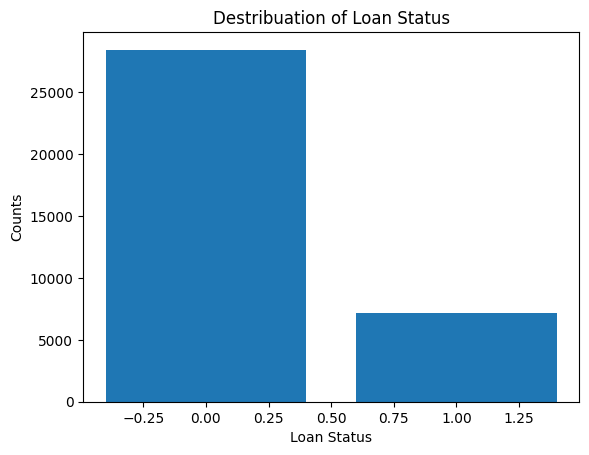

In [33]:
# check for imbalanced data
counts = y.value_counts()
plt.bar(counts.index , counts.values)
plt.title('Destribuation of Loan Status')
plt.xlabel('Loan Status')
plt.ylabel('Counts')
plt.show()

## Splitting Data 

In [34]:
X_train , X_test , y_train , y_test = train_test_split(X , y , test_size = 0.25 , random_state = 44 , shuffle = True)

In [35]:
print(f'Shape of X_Train {X_train.shape}')
print(f'Shape of X_Test {X_test.shape}')
print(f'Shape of Y_Train {y_train.shape}')
print(f'Shape of Y_Test {y_test.shape}')

Shape of X_Train (26722, 9)
Shape of X_Test (8908, 9)
Shape of Y_Train (26722,)
Shape of Y_Test (8908,)


### Handle Imbalanced Data

In [36]:
from imblearn.over_sampling import SMOTE
resampler = SMOTE()
X_train_resample,y_train_resample = resampler.fit_resample(X_train, y_train)

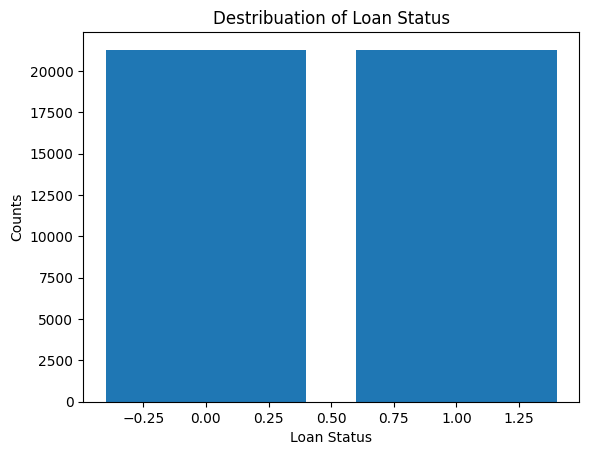

In [37]:
counts = y_train_resample.value_counts()
plt.bar(counts.index , counts.values)
plt.title('Destribuation of Loan Status')
plt.xlabel('Loan Status')
plt.ylabel('Counts')
plt.show()

In [38]:
# Show New Correlation
combined = pd.DataFrame(X_train_resample, columns=X_train.columns)
combined['loan_status'] = y_train_resample
fig = px.imshow(combined.corr(), 
                text_auto=True, 
                color_continuous_scale = "tempo",  
                template='plotly_dark',
                title="Correlation Heatmap")
fig.update_layout(
    width=1000, 
    height=800  
)
fig.show()

## Modeling

#### Use Different Models Algorithm

In [39]:
def train(model,model_name,X_train,y_train,X_test,y_test):
    model.fit(X_train,y_train)
    model_train_score = model.score(X_train,y_train)
    model_test_score = model.score(X_test,y_test)
    print(f"{model_name} model score on Training data: {model_train_score * 100}%\n{model_name} model score on Testing data: {model_test_score * 100}%")

def class_report(model,X_test,y_test):
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))

def plot_Conf_Matrix(model,X_test,y_test):
    y_pred = model.predict(X_test)
    CM = confusion_matrix(y_test, y_pred)
    sns.heatmap(CM, center=True, cmap='Blues_r', annot=True, fmt='g') 
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

#### Logistic Regression

In [40]:
lr = LogisticRegression()
train(lr, "Logistic Regression",X_train_resample,y_train_resample,X_test,y_test)

Logistic Regression model score on Training data: 74.74168701859854%
Logistic Regression model score on Testing data: 72.38437359676695%


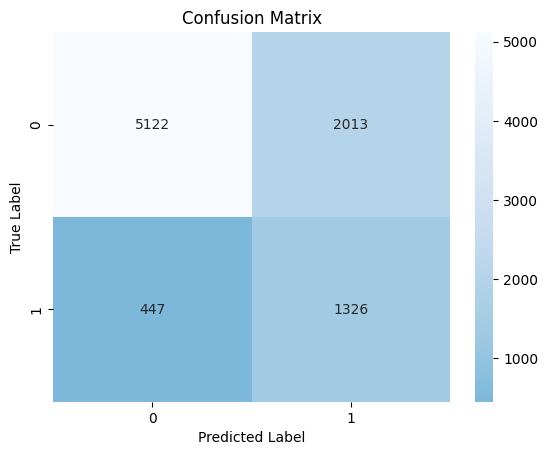

In [41]:
plot_Conf_Matrix(lr,X_test,y_test)

In [42]:
class_report(lr,X_test,y_test)

              precision    recall  f1-score   support

           0       0.92      0.72      0.81      7135
           1       0.40      0.75      0.52      1773

    accuracy                           0.72      8908
   macro avg       0.66      0.73      0.66      8908
weighted avg       0.82      0.72      0.75      8908



#### Random Forest

In [43]:
rf = RandomForestClassifier(n_estimators = 40 , max_depth = 17)
train(rf, "Random Forest",X_train_resample,y_train_resample,X_test,y_test)

Random Forest model score on Training data: 97.45679128311103%
Random Forest model score on Testing data: 90.25594970812753%


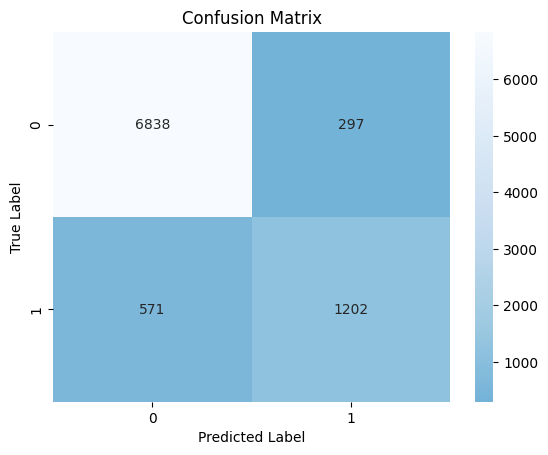

In [44]:
plot_Conf_Matrix(rf,X_test,y_test)

In [45]:
class_report(rf,X_test,y_test)

              precision    recall  f1-score   support

           0       0.92      0.96      0.94      7135
           1       0.80      0.68      0.73      1773

    accuracy                           0.90      8908
   macro avg       0.86      0.82      0.84      8908
weighted avg       0.90      0.90      0.90      8908



#### KNN

In [46]:
knn = KNeighborsClassifier()
train(knn, "KNN",X_train_resample,y_train_resample,X_test,y_test)

KNN model score on Training data: 87.93678376855158%
KNN model score on Testing data: 76.77368657386619%


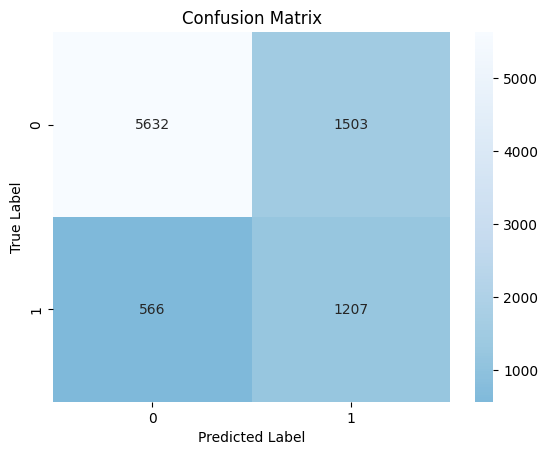

In [47]:
plot_Conf_Matrix(knn,X_test,y_test)

In [48]:
class_report(knn,X_test,y_test)

              precision    recall  f1-score   support

           0       0.91      0.79      0.84      7135
           1       0.45      0.68      0.54      1773

    accuracy                           0.77      8908
   macro avg       0.68      0.74      0.69      8908
weighted avg       0.82      0.77      0.78      8908



## Decision Tree

In [55]:
dt_model = DecisionTreeClassifier(max_depth=15)
train(dt_model, "Decision Tree",X_train_resample,y_train_resample,X_test,y_test)

Decision Tree model score on Training data: 94.54724779259816%
Decision Tree model score on Testing data: 87.53929052537045%


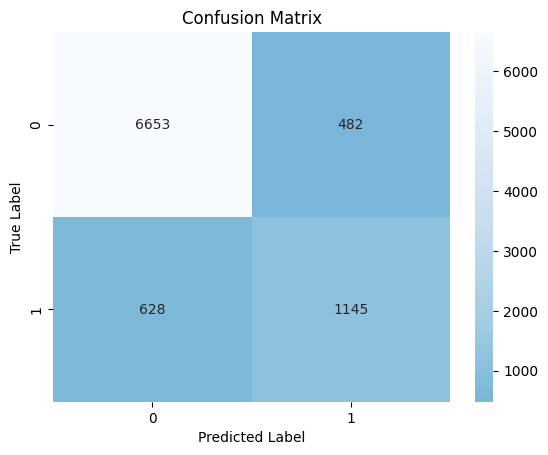

In [56]:
plot_Conf_Matrix(dt_model,X_test,y_test)

In [57]:
class_report(dt_model,X_test,y_test)

              precision    recall  f1-score   support

           0       0.91      0.93      0.92      7135
           1       0.70      0.65      0.67      1773

    accuracy                           0.88      8908
   macro avg       0.81      0.79      0.80      8908
weighted avg       0.87      0.88      0.87      8908



## Xgboost

In [58]:
xgboost = model = XGBClassifier(objective = "binary:logistic" , subsample = 0.7 , min_child_weight = 3,
                                max_depth = 25 , learning_rate = 0.1 , gamma = 0 , colsample_bytree = 0.5,)
train(xgboost, "Xgboost",X_train_resample,y_train_resample,X_test,y_test)

Xgboost model score on Training data: 98.32566222055232%
Xgboost model score on Testing data: 91.62550516389763%


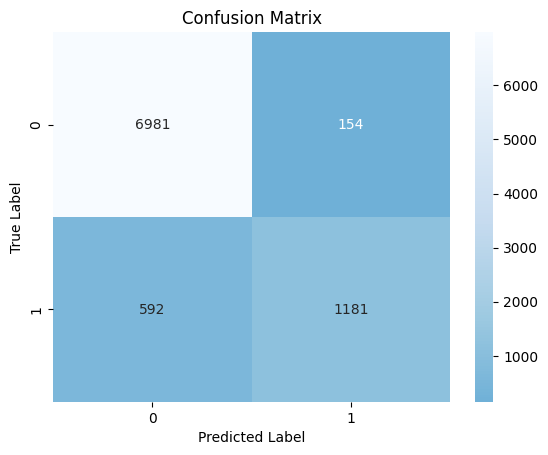

In [59]:
plot_Conf_Matrix(xgboost,X_test,y_test)

In [60]:
class_report(xgboost,X_test,y_test)

              precision    recall  f1-score   support

           0       0.92      0.98      0.95      7135
           1       0.88      0.67      0.76      1773

    accuracy                           0.92      8908
   macro avg       0.90      0.82      0.85      8908
weighted avg       0.91      0.92      0.91      8908



- Best Model is XGBoostClassifier with 92%

## Save XGBoost Model 

In [61]:
joblib.dump(xgboost,'xgboost.pkl')
joblib.dump(X_test,'x_test.pkl')
joblib.dump(y_test,'y_test.pkl')

['y_test.pkl']